In [1]:
import pandas as pd
import numpy as np
from mstamp_stamp import mstamp
import matplotlib.pyplot as plt

In [2]:
data = pd.read_excel("data_akbilgic.xlsx")

/usr/local/lib/python3.9/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [3]:
data

,Unnamed: 0,TL BASED,USD BASED,imkb_x,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9
0,date,ISE,ISE,SP,DAX,FTSE,NIKKEI,BOVESPA,EU,EM
1,2009-01-05 00:00:00,0.035754,0.038376,-0.004679,0.002193,0.003894,0,0.03119,0.012698,0.028524
2,2009-01-06 00:00:00,0.025426,0.031813,0.007787,0.008455,0.012866,0.004162,0.01892,0.011341,0.008773
3,2009-01-07 00:00:00,-0.028862,-0.026353,-0.030469,-0.017833,-0.028735,0.017293,-0.035899,-0.017073,-0.020015
4,2009-01-08 00:00:00,-0.062208,-0.084716,0.003391,-0.011726,-0.000466,-0.040061,0.028283,-0.005561,-0.019424
...,...,...,...,...,...,...,...,...,...,...
532,2011-02-16 00:00:00,0.008599,0.0134,0.006238,0.001925,0.007952,0.005717,0.018371,0.006975,0.003039
533,2011-02-17 00:00:00,0.00931,0.015977,0.003071,-0.001186,0.000345,0.00262,0.001686,-0.000581,0.001039
534,2011-02-18 00:00:00,0.000191,-0.001653,0.001923,0.002872,-0.000723,0.000568,0.005628,0.000572,0.006938
535,2011-02-21 00:00:00,-0.013069,-0.013706,-0.020742,-0.014239,-0.011275,0.001358,-0.011942,-0.012615,-0.000958


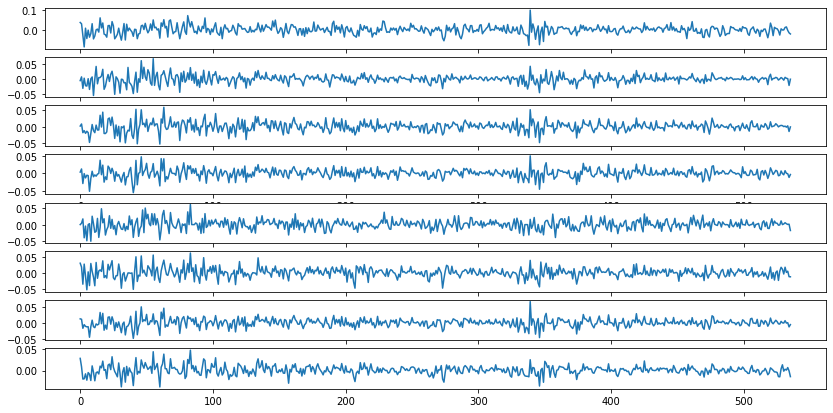

In [4]:
data_copy = data.drop(columns=["Unnamed: 0", "TL BASED"], index=[0])

multivariate_time_series = data_copy.to_numpy()
fig, axs =  plt.subplots(8, 1, figsize=(14,7))
for i in range(8):
    axs[i].plot(multivariate_time_series[:, i])
plt.show()

In [94]:
def plot_motifs(matrix_profile, data, sub_len, dimensionality=None):
    motif_at = matrix_profile[dimensionality - 1, :].argsort()[:2]

    plt.figure(figsize=(20, 10))
    for i in range(data.shape[1]):
        plt.subplot(data.shape[1] + 1, 1, i + 1)
        plt.plot(data.T[i, :])
        plt.title('$T_{}$'.format(i + 1))
        for m in motif_at:
            plt.plot(range(m, m + sub_len), data.T[i, :][m:m + sub_len], c='r')
        plt.xlim((0, matrix_profile.shape[1]))

    plt.subplot(data.shape[1] + 1, 1, data.shape[1] + 1)
    plt.title('{}-dimensional Matrix Profile'.format(dimensionality))
    plt.plot(matrix_profile[dimensionality - 1, :])
    for m in motif_at:
        plt.axvline(m, c='r')
    plt.xlim((0, matrix_profile.shape[1]))
    plt.tight_layout()

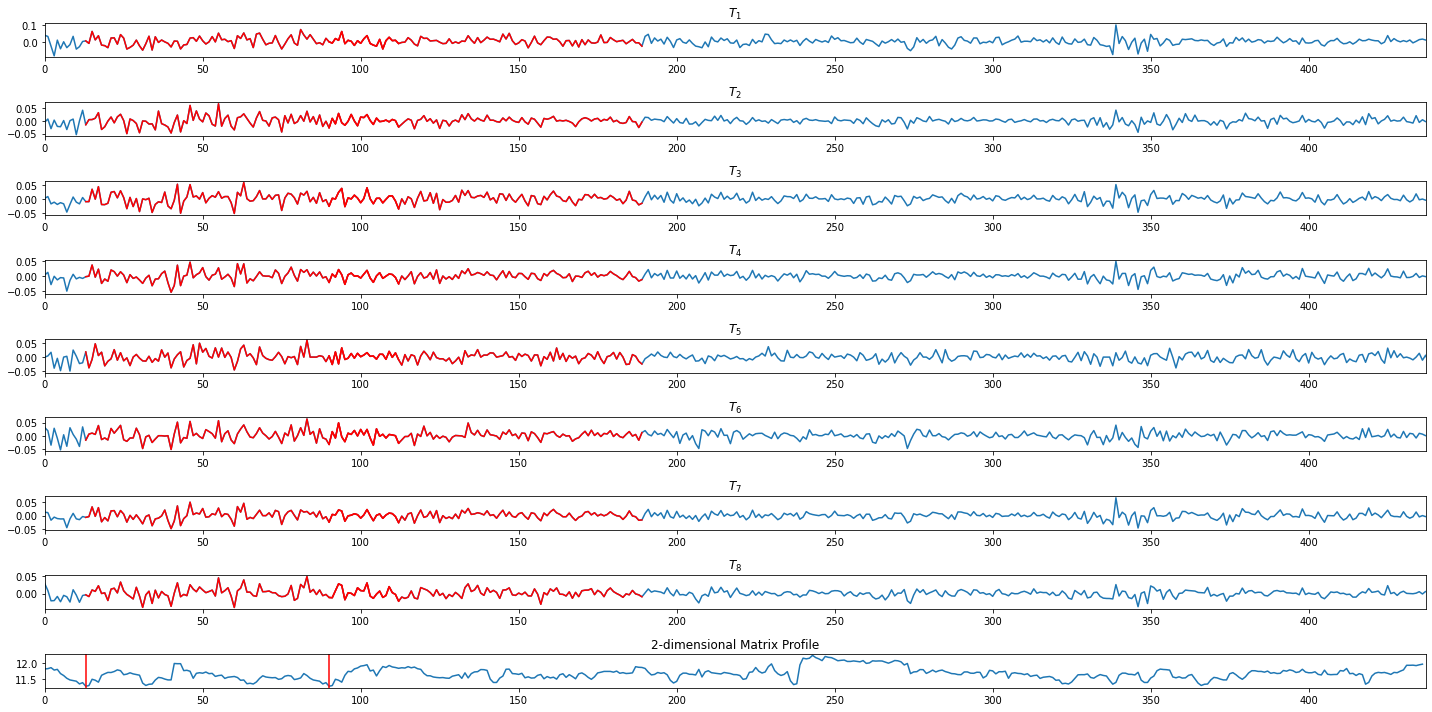

In [96]:
# plot the matrix profil for one dimension

mat_pro_approx, pro_idx_approx = mstamp(multivariate_time_series.T, 100, return_dimension=False)
plot_motifs(mat_pro_approx, multivariate_time_series, 100, 2)

In [5]:
def RMSE(matprof_1, matprof_2):
    return np.sum(np.mean(np.square(matprof_1 - matprof_2)))

527
526

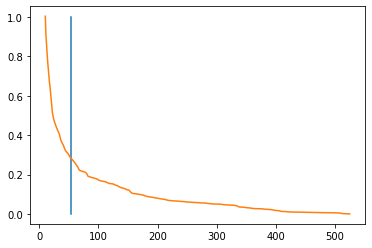

In [16]:
# compute rmse
sub_len = 10
sub_num = multivariate_time_series.shape[0] - sub_len + 1
print(sub_num)

mat_pro_ref, pro_idx_ref = mstamp(multivariate_time_series.T, 10)
rmse = []
for i in range(1, sub_num):
    print("\r"+ str(i), end="")
    mat_pro_approx, pro_idx_approx = mstamp(multivariate_time_series.T, 10, i, random=True)
    rmse.append(RMSE(mat_pro_approx, mat_pro_ref))
    
d = np.linspace(0, 1, 100)
plt.plot([int(0.1*multivariate_time_series.shape[0]) for i in range(100)], d)
plt.plot(rmse)
plt.show()

Progress [################################################# ] 299 it, sub = 303

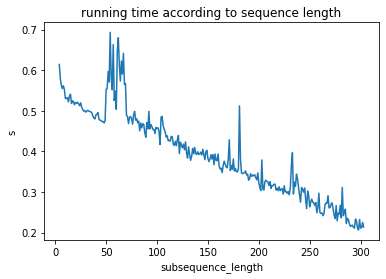

In [9]:
# compute time sub sequence
import time
n = 300
subsequence_lentgh = 4 + np.arange(n)
sec = []
i = 0
for sub in subsequence_lentgh:
    print('\rProgress [{0:<50s}] {1} it, sub = {2}'.format("#"*int(i/n*50), i, sub), end="")
    tic_in = time.time()
    mat_pro_approx, pro_idx_approx = mstamp(multivariate_time_series.T, sub)
    tic_out = time.time()
    sec.append(tic_out-tic_in)
    i += 1
plt.plot(subsequence_lentgh, sec)
plt.title("running time according to sequence length")
plt.xlabel("subsequence_length")
plt.ylabel("second")
plt.show()

In [117]:
test = np.array([0, 0, 0, 1, 3])
np.sum(test != 0)

2

In [317]:
def Dnorm(T):
    m, dim = T.shape
    maxi = np.max(T, axis=0)
    mini = np.min(T, axis=0)
    b = int(T.nbytes/(m*dim))
    normalized = (T-mini[None,:])/(maxi[None,:] - mini[None,:])*(np.power(2, b) - 1) + 1
    return normalized.astype(int) + 1

def DL(T):
    """compute DL of T
    T must be normalized
    """
    m, dim = T.shape
    return T.nbytes/dim

def RDL(t_c, t_h):
    """compute RDL of t_c according to t_h
    t_c and t_h must be normalized
    the bit number encoding b of t_c and t_h must be equal
    """
    diff = t_c - t_h
    gamma = np.sum(diff != 0)
    m, dim = t_c.shape
    b = int(t_c.nbytes/(m*dim))
    return gamma*(np.log2(m) + b)/dim

def bit(multivariate_time_series, compressible_set_index, hypothesis_index, sub_len, unexplored_index=None):
    """Compute the bits required to store compressible_set_index according to hypothesis_index
    """
    compressible_set = []
    hypothesis_set = []
    for idx, prof in compressible_set_index:
        compressible_set.append(Dnorm(multivariate_time_series[idx: idx + sub_len, prof]))
    for idx, prof in hypothesis_index:
        hypothesis_set.append(Dnorm(multivariate_time_series[idx: idx + sub_len, prof]))
    h = len(hypothesis_set)
    res = 0
    for t_c in compressible_set:
        min_rdl = RDL(t_c, hypothesis_set[0])
        for i in range(1, h):
            rdl = RDL(t_c, hypothesis_set[i])
            if rdl <= min_rdl:
                min_rdl = rdl
        res += min_rdl
    for t_h in hypothesis_set:
        res += DL(t_h)
    if unexplored_index is not None:
        for t_u in unexplored_index:
            res += DL(t_u)
    return res

def MDL(matrix_profile, multivariate_time_series, sub_len, profile):
    """mdl methods, compute the bits that are needed to store the 
    two subsequence selected for each dimension
    """
    dimension, t = matrix_profile.shape
    bits = []
    for d in range(dimension):
        t_1, t_2 = matrix_profile[d, :].argsort()[:2]
        hypothesis_index = [(t_1, profile[d][:,t_1])]
        compressible_set_index = [(t_2, profile[d][:,t_2])]
        #unexplored_index = np.arange(t-sub_len)
        #unexplored_index = unexplored_index[unexplored_index != t_1]
        #unexplored_index = unexplored_index[unexplored_index != t_2]
        bits.append(bit(multivariate_time_series, compressible_set_index, hypothesis_index, sub_len))
    return np.array(bits)

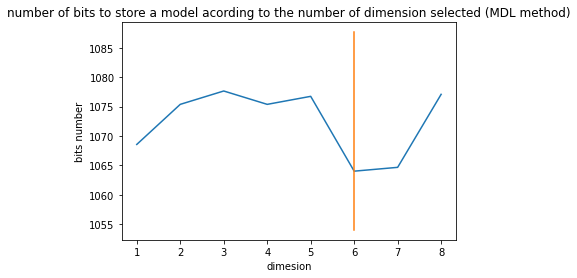

In [321]:
mat_pro, pro_idx, profile = mstamp(multivariate_time_series.T, 50, return_dimension=True)
bits = MDL(mat_pro, multivariate_time_series, 50, profile)
argmin = np.argmin(bits)
y = np.linspace(np.min(bits)-10, np.max(bits)+10, 100)
plt.plot(np.arange(8) + 1, bits)
plt.plot([argmin + 1 for i in range(100)], y)
plt.xlabel("dimesion")
plt.ylabel("bits number")
plt.title("number of bits to store a model acording to the number of dimension selected (MDL method)")
plt.show()

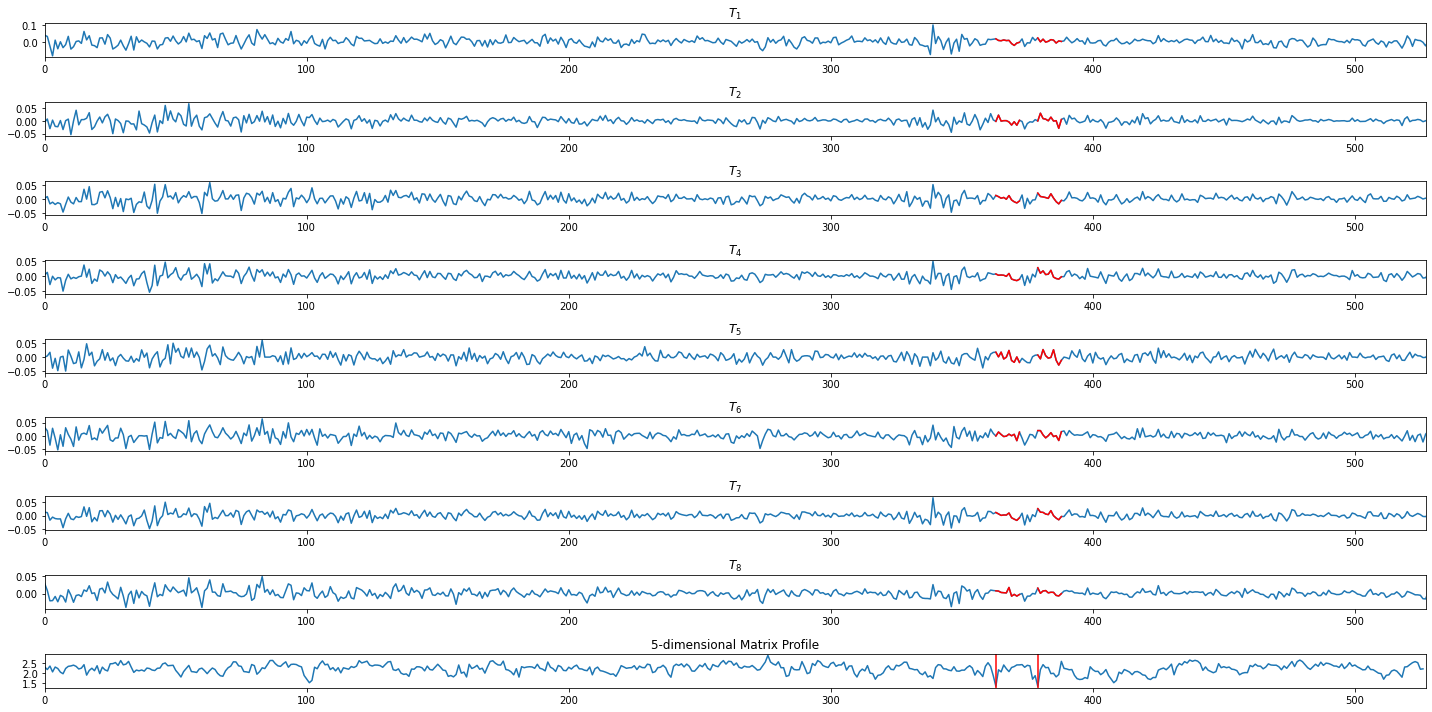

In [322]:
# plot the matrix profil for best dimension dimension

mat_pro_approx, pro_idx_approx = mstamp(multivariate_time_series.T, 10, return_dimension=False)
plot_motifs(mat_pro_approx, multivariate_time_series, 10, argmin)

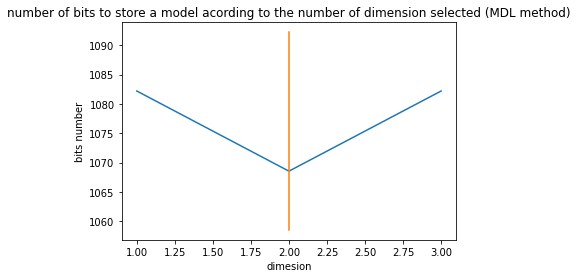

In [319]:
import scipy.io as sio

mat = sio.loadmat('toy_data.mat')
data = mat['data']
sub_len = mat['sub_len'][0][0]

mat_pro, pro_idx, profile = mstamp(data.T, sub_len, return_dimension=True)
bits = MDL(mat_pro, data, 50, profile)
argmin = np.argmin(bits)
y = np.linspace(np.min(bits)-10, np.max(bits)+10, 100)
plt.plot(np.arange(3) + 1, bits)
plt.plot([argmin + 1 for i in range(100)], y)
plt.xlabel("dimesion")
plt.ylabel("bits number")
plt.title("number of bits to store a model acording to the number of dimension selected (MDL method)")
plt.show()

In [201]:
t_c = np.array([[1, 3, 4, 5, 4, 3, 6, 15, 14, 13, 12, 0, 2, 4, 2, 6, 10, 11, 9, 3]])
t_h = np.array([[1, 3, 3, 5, 4, 3, 6, 15, 14, 13, 12, 0, 2, 3, 2, 6, 4, 3, 1, 0]])
RDL(t_c, t_h, h=2)

8
20
6


74.93156856932417